In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
dataset_name = 'ravdess'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run0/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 4

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [8]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [9]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [11]:
codebook_pretrained_path = f'../scb7_models/ravdess/codebook.step=10000.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [12]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [13]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [14]:
trainer.setup(model=model, lr=learning_rate)

In [15]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▍                                                                                  | 0.4927536231884051/100 [00:31<4:50:26, 175.13s/it]

Epoch: 1	Loss: 1.717 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.717]	Val_acc: 6/27 (22.22%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=1.step=51.loss=1.717.val_acc=0.222.pt


  1%|█                                                                                    | 1.297101449275365/100 [01:12<1:04:35, 39.26s/it]

Correct: 50/135 (0.3704)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=1.step=100.test_acc=0.3704.pt
{'acc_unweighted': tensor(0.3262, device='cuda:0'),
 'acc_weighted': tensor(0.3704, device='cuda:0'),
 'f1s_unweighted': tensor(0.2389, device='cuda:0'),
 'f1s_weighted': tensor(0.2717, device='cuda:0'),
 'rocauc': tensor(0.7347, device='cuda:0'),
 'uar': tensor(0.3262, device='cuda:0'),
 'wap': tensor(0.4895, device='cuda:0')}
{'acc_detail': tensor([0.8947, 0.0000, 0.0256, 0.3846], device='cuda:0'),
 'f1s_detail': tensor([0.5965, 0.0000, 0.0500, 0.3093], device='cuda:0'),
 'precision_detail': tensor([0.4474, 0.0000, 1.0000, 0.2586], device='cuda:0'),
 'recall_detail': tensor([0.8947, 0.0000, 0.0256, 0.3846], device='cuda:0'),
 'rocauc_detail': tensor([0.8646, 0.7645, 0.7495, 0.5601], device='cuda:0')}
tensor([[34,  0,  0,  4],
        [ 5,  0,  0, 14],
        [13,  0,  1, 25],
        [24,  0,  0, 15]], device='cuda:0')


  2%|█▌                                                                                  | 1.789855072463773/100 [01:43<4:49:12, 176.69s/it]

Epoch: 2	Loss: 1.148 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.148]	Val_acc: 12/27 (44.44%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=2.step=151.loss=1.148.val_acc=0.444.pt


  3%|██▎                                                                                | 2.7608695652174005/100 [02:42<4:43:58, 175.22s/it]

Epoch: 3	Loss: 1.470 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.470]	Val_acc: 10/27 (37.04%)



  4%|███▏                                                                                | 3.731884057971028/100 [03:42<4:39:24, 174.15s/it]

Epoch: 4	Loss: 1.246 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.246]	Val_acc: 11/27 (40.74%)



  5%|███▉                                                                                | 4.702898550724612/100 [04:41<4:39:42, 176.11s/it]

Epoch: 5	Loss: 2.459 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.459]	Val_acc: 11/27 (40.74%)



  6%|████▊                                                                                | 5.67391304347818/100 [05:41<4:37:14, 176.35s/it]

Epoch: 6	Loss: 1.451 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.451]	Val_acc: 13/27 (48.15%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=6.step=551.loss=1.451.val_acc=0.481.pt


  7%|█████▌                                                                              | 6.644927536231748/100 [06:40<4:33:23, 175.71s/it]

Epoch: 7	Loss: 0.850 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.850]	Val_acc: 13/27 (48.15%)



  8%|██████▍                                                                             | 7.615942028985316/100 [07:38<4:26:35, 173.14s/it]

Epoch: 8	Loss: 1.428 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.428]	Val_acc: 13/27 (48.15%)



  9%|███████▏                                                                            | 8.586956521738884/100 [08:38<4:24:25, 173.56s/it]

Epoch: 9	Loss: 1.227 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.227]	Val_acc: 12/27 (44.44%)



 10%|████████                                                                            | 9.557971014492452/100 [09:37<4:24:28, 175.46s/it]

Epoch: 10	Loss: 0.950 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.950]	Val_acc: 12/27 (44.44%)



 11%|████████▊                                                                           | 10.52898550724602/100 [10:36<4:24:48, 177.58s/it]

Epoch: 11	Loss: 0.932 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.932]	Val_acc: 13/27 (48.15%)



 11%|█████████▊                                                                             | 11.33333333333293/100 [11:17<58:23, 39.51s/it]

Correct: 69/135 (0.5111)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=11.step=1100.test_acc=0.5111.pt
{'acc_unweighted': tensor(0.4467, device='cuda:0'),
 'acc_weighted': tensor(0.5111, device='cuda:0'),
 'f1s_unweighted': tensor(0.4114, device='cuda:0'),
 'f1s_weighted': tensor(0.4708, device='cuda:0'),
 'rocauc': tensor(0.8167, device='cuda:0'),
 'uar': tensor(0.4467, device='cuda:0'),
 'wap': tensor(0.4675, device='cuda:0')}
{'acc_detail': tensor([0.6842, 0.0000, 0.6923, 0.4103], device='cuda:0'),
 'f1s_detail': tensor([0.6265, 0.0000, 0.5192, 0.5000], device='cuda:0'),
 'precision_detail': tensor([0.5778, 0.0000, 0.4154, 0.6400], device='cuda:0'),
 'recall_detail': tensor([0.6842, 0.0000, 0.6923, 0.4103], device='cuda:0'),
 'rocauc_detail': tensor([0.9007, 0.8453, 0.7687, 0.7521], device='cuda:0')}
tensor([[26,  0,  6,  6],
        [ 4,  0, 15,  0],
        [ 9,  0, 27,  3],
        [ 6,  0, 17, 16]], device='cuda:0')


 12%|█████████▊                                                                         | 11.826086956521308/100 [11:49<4:17:24, 175.16s/it]

Epoch: 12	Loss: 0.929 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.929]	Val_acc: 11/27 (40.74%)



 13%|██████████▌                                                                        | 12.797101449274876/100 [12:48<4:13:44, 174.59s/it]

Epoch: 13	Loss: 1.250 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.250]	Val_acc: 13/27 (48.15%)



 14%|███████████▍                                                                       | 13.768115942028444/100 [13:47<4:14:04, 176.79s/it]

Epoch: 14	Loss: 0.900 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.900]	Val_acc: 13/27 (48.15%)



 15%|████████████▏                                                                      | 14.739130434782012/100 [14:46<4:10:28, 176.27s/it]

Epoch: 15	Loss: 1.165 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.165]	Val_acc: 10/27 (37.04%)



 16%|█████████████▏                                                                      | 15.71014492753558/100 [15:46<4:09:24, 177.54s/it]

Epoch: 16	Loss: 0.555 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.555]	Val_acc: 15/27 (55.56%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=16.step=1551.loss=0.555.val_acc=0.556.pt


 17%|██████████████                                                                      | 16.68115942028915/100 [16:45<4:02:14, 174.44s/it]

Epoch: 17	Loss: 0.721 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.721]	Val_acc: 15/27 (55.56%)



 18%|██████████████▋                                                                    | 17.652173913042716/100 [17:44<3:59:23, 174.43s/it]

Epoch: 18	Loss: 1.216 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.216]	Val_acc: 16/27 (59.26%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=18.step=1751.loss=1.216.val_acc=0.593.pt


 19%|███████████████▍                                                                   | 18.623188405796284/100 [18:43<3:56:17, 174.22s/it]

Epoch: 19	Loss: 0.422 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.422]	Val_acc: 14/27 (51.85%)



 20%|████████████████▎                                                                  | 19.594202898549852/100 [19:43<3:55:27, 175.70s/it]

Epoch: 20	Loss: 0.558 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.558]	Val_acc: 11/27 (40.74%)



 21%|█████████████████▎                                                                  | 20.56521739130342/100 [20:42<3:51:46, 175.07s/it]

Epoch: 21	Loss: 1.511 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.511]	Val_acc: 14/27 (51.85%)



 21%|██████████████████▌                                                                    | 21.36956521739033/100 [21:22<50:57, 38.88s/it]

Correct: 73/135 (0.5407)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=21.step=2100.test_acc=0.5407.pt
{'acc_unweighted': tensor(0.4868, device='cuda:0'),
 'acc_weighted': tensor(0.5407, device='cuda:0'),
 'f1s_unweighted': tensor(0.4685, device='cuda:0'),
 'f1s_weighted': tensor(0.5162, device='cuda:0'),
 'rocauc': tensor(0.8306, device='cuda:0'),
 'uar': tensor(0.4868, device='cuda:0'),
 'wap': tensor(0.5308, device='cuda:0')}
{'acc_detail': tensor([0.8421, 0.1053, 0.6410, 0.3590], device='cuda:0'),
 'f1s_detail': tensor([0.7442, 0.1333, 0.5376, 0.4590], device='cuda:0'),
 'precision_detail': tensor([0.6667, 0.1818, 0.4630, 0.6364], device='cuda:0'),
 'recall_detail': tensor([0.8421, 0.1053, 0.6410, 0.3590], device='cuda:0'),
 'rocauc_detail': tensor([0.9293, 0.7818, 0.8034, 0.8080], device='cuda:0')}
tensor([[32,  0,  3,  3],
        [ 3,  2, 14,  0],
        [ 4,  5, 25,  5],
        [ 9,  4, 12, 14]], device='cuda:0')


 22%|██████████████████▎                                                                 | 21.86231884057871/100 [21:54<3:48:55, 175.79s/it]

Epoch: 22	Loss: 1.181 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.181]	Val_acc: 12/27 (44.44%)



 23%|██████████████████▉                                                                | 22.833333333332277/100 [22:53<3:45:29, 175.33s/it]

Epoch: 23	Loss: 0.108 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.108]	Val_acc: 13/27 (48.15%)



 24%|███████████████████▊                                                               | 23.804347826085845/100 [23:52<3:41:17, 174.26s/it]

Epoch: 24	Loss: 0.116 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.116]	Val_acc: 16/27 (59.26%)



 25%|████████████████████▌                                                              | 24.775362318839413/100 [24:51<3:42:08, 177.19s/it]

Epoch: 25	Loss: 0.056 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.056]	Val_acc: 13/27 (48.15%)



 26%|█████████████████████▋                                                              | 25.74637681159298/100 [25:50<3:38:04, 176.22s/it]

Epoch: 26	Loss: 0.486 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.486]	Val_acc: 16/27 (59.26%)



 27%|██████████████████████▍                                                             | 26.71739130434655/100 [26:50<3:35:59, 176.84s/it]

Epoch: 27	Loss: 0.264 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.264]	Val_acc: 18/27 (66.67%)

Saved new best val model: ../scb16_models/ravdess/run0model.epoch=27.step=2651.loss=0.264.val_acc=0.667.pt


 28%|██████████████████████▉                                                            | 27.688405797100117/100 [27:49<3:30:12, 174.42s/it]

Epoch: 28	Loss: 0.404 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.404]	Val_acc: 13/27 (48.15%)



 29%|███████████████████████▊                                                           | 28.659420289853685/100 [28:48<3:29:02, 175.81s/it]

Epoch: 29	Loss: 1.075 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.075]	Val_acc: 13/27 (48.15%)



 30%|████████████████████████▌                                                          | 29.630434782607253/100 [29:48<3:25:06, 174.88s/it]

Epoch: 30	Loss: 0.400 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.400]	Val_acc: 15/27 (55.56%)



 31%|█████████████████████████▋                                                          | 30.60144927536082/100 [30:47<3:24:27, 176.76s/it]

Epoch: 31	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 13/27 (48.15%)



 31%|███████████████████████████▎                                                           | 31.40579710144773/100 [31:28<44:35, 39.01s/it]

Correct: 83/135 (0.6148)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=31.step=3100.test_acc=0.6148.pt
{'acc_unweighted': tensor(0.5574, device='cuda:0'),
 'acc_weighted': tensor(0.6148, device='cuda:0'),
 'f1s_unweighted': tensor(0.5548, device='cuda:0'),
 'f1s_weighted': tensor(0.6036, device='cuda:0'),
 'rocauc': tensor(0.8508, device='cuda:0'),
 'uar': tensor(0.5574, device='cuda:0'),
 'wap': tensor(0.6126, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.1579, 0.6667, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7792, 0.2143, 0.5591, 0.6667], device='cuda:0'),
 'precision_detail': tensor([0.7692, 0.3333, 0.4815, 0.7273], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.1579, 0.6667, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9360, 0.8362, 0.8226, 0.8085], device='cuda:0')}
tensor([[30,  0,  4,  4],
        [ 2,  3, 14,  0],
        [ 3,  5, 26,  5],
        [ 4,  1, 10, 24]], device='cuda:0')


 32%|██████████████████████████▊                                                         | 31.89855072463611/100 [31:59<3:19:46, 176.00s/it]

Epoch: 32	Loss: 0.072 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.072]	Val_acc: 17/27 (62.96%)



 33%|███████████████████████████▌                                                        | 32.86956521738968/100 [32:59<3:17:11, 176.25s/it]

Epoch: 33	Loss: 0.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.065]	Val_acc: 16/27 (59.26%)



 34%|████████████████████████████                                                       | 33.840579710143246/100 [33:58<3:13:02, 175.07s/it]

Epoch: 34	Loss: 0.201 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.201]	Val_acc: 16/27 (59.26%)



 35%|█████████████████████████████▏                                                      | 34.81159420289681/100 [34:58<3:10:14, 175.10s/it]

Epoch: 35	Loss: 0.152 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.152]	Val_acc: 15/27 (55.56%)



 36%|██████████████████████████████                                                      | 35.78260869565038/100 [35:57<3:07:07, 174.84s/it]

Epoch: 36	Loss: 0.187 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.187]	Val_acc: 14/27 (51.85%)



 37%|██████████████████████████████▊                                                     | 36.75362318840395/100 [36:56<3:05:26, 175.92s/it]

Epoch: 37	Loss: 0.424 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.424]	Val_acc: 16/27 (59.26%)



 38%|███████████████████████████████▋                                                    | 37.72463768115752/100 [37:55<3:01:18, 174.69s/it]

Epoch: 38	Loss: 0.350 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.350]	Val_acc: 12/27 (44.44%)



 39%|████████████████████████████████                                                   | 38.695652173911085/100 [38:55<3:01:05, 177.24s/it]

Epoch: 39	Loss: 0.023 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.023]	Val_acc: 12/27 (44.44%)



 40%|█████████████████████████████████▎                                                  | 39.66666666666465/100 [39:54<2:56:54, 175.94s/it]

Epoch: 40	Loss: 0.326 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.326]	Val_acc: 14/27 (51.85%)



 41%|██████████████████████████████████▏                                                 | 40.63768115941822/100 [40:53<2:51:26, 173.29s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 41%|████████████████████████████████████                                                   | 41.44202898550513/100 [41:34<38:40, 39.64s/it]

Correct: 82/135 (0.6074)
{'acc_unweighted': tensor(0.6250, device='cuda:0'),
 'acc_weighted': tensor(0.6074, device='cuda:0'),
 'f1s_unweighted': tensor(0.5988, device='cuda:0'),
 'f1s_weighted': tensor(0.6109, device='cuda:0'),
 'rocauc': tensor(0.8510, device='cuda:0'),
 'uar': tensor(0.6250, device='cuda:0'),
 'wap': tensor(0.6395, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.7368, 0.4615, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7632, 0.5091, 0.5143, 0.6087], device='cuda:0'),
 'precision_detail': tensor([0.7632, 0.3889, 0.5806, 0.7000], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.7368, 0.4615, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9399, 0.8689, 0.7853, 0.8101], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 0, 14,  4,  1],
        [ 4, 14, 18,  3],
        [ 5,  7,  6, 21]], device='cuda:0')


 42%|███████████████████████████████████▏                                                | 41.93478260869351/100 [42:06<2:48:34, 174.19s/it]

Epoch: 42	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 14/27 (51.85%)



 43%|████████████████████████████████████                                                | 42.90579710144708/100 [43:05<2:46:41, 175.17s/it]

Epoch: 43	Loss: 0.106 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.106]	Val_acc: 13/27 (48.15%)



 44%|████████████████████████████████████▍                                              | 43.876811594200646/100 [44:04<2:44:20, 175.70s/it]

Epoch: 44	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 45%|█████████████████████████████████████▏                                             | 44.847826086954214/100 [45:03<2:41:34, 175.77s/it]

Epoch: 45	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 17/27 (62.96%)



 46%|██████████████████████████████████████▍                                             | 45.81884057970778/100 [46:02<2:36:51, 173.70s/it]

Epoch: 46	Loss: 0.018 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.018]	Val_acc: 17/27 (62.96%)



 47%|███████████████████████████████████████▎                                            | 46.78985507246135/100 [47:00<2:36:34, 176.55s/it]

Epoch: 47	Loss: 0.025 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.025]	Val_acc: 14/27 (51.85%)



 48%|████████████████████████████████████████                                            | 47.76086956521492/100 [47:59<2:32:28, 175.12s/it]

Epoch: 48	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 15/27 (55.56%)



 49%|████████████████████████████████████████▍                                          | 48.731884057968486/100 [48:58<2:30:40, 176.33s/it]

Epoch: 49	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 14/27 (51.85%)



 50%|█████████████████████████████████████████▎                                         | 49.702898550722054/100 [49:57<2:27:05, 175.47s/it]

Epoch: 50	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 15/27 (55.56%)



 51%|██████████████████████████████████████████▌                                         | 50.67391304347562/100 [50:56<2:22:52, 173.79s/it]

Epoch: 51	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 15/27 (55.56%)



 51%|████████████████████████████████████████████▊                                          | 51.47826086956253/100 [51:37<31:29, 38.95s/it]

Correct: 86/135 (0.6370)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=51.step=5100.test_acc=0.6370.pt
{'acc_unweighted': tensor(0.6373, device='cuda:0'),
 'acc_weighted': tensor(0.6370, device='cuda:0'),
 'f1s_unweighted': tensor(0.6241, device='cuda:0'),
 'f1s_weighted': tensor(0.6381, device='cuda:0'),
 'rocauc': tensor(0.8603, device='cuda:0'),
 'uar': tensor(0.6373, device='cuda:0'),
 'wap': tensor(0.6468, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.6316, 0.5128, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7792, 0.5217, 0.5556, 0.6400], device='cuda:0'),
 'precision_detail': tensor([0.7692, 0.4444, 0.6061, 0.6667], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.6316, 0.5128, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9405, 0.8879, 0.8034, 0.8096], device='cuda:0')}
tensor([[30,  1,  2,  5],
        [ 0, 12,  5,  2],
        [ 4, 10, 20,  5],
        [ 5,  4,  6, 24]], device='cuda:0')


 52%|███████████████████████████████████████████▋                                        | 51.97101449275091/100 [52:09<2:20:31, 175.55s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 53%|████████████████████████████████████████████▍                                       | 52.94202898550448/100 [53:09<2:18:35, 176.70s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 54%|█████████████████████████████████████████████▎                                      | 53.91304347825805/100 [54:09<2:17:21, 178.83s/it]

Epoch: 54	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 55%|█████████████████████████████████████████████▌                                     | 54.884057971011615/100 [55:09<2:14:05, 178.33s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 56%|██████████████████████████████████████████████▉                                     | 55.85507246376518/100 [56:09<2:11:32, 178.79s/it]

Epoch: 56	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 57%|███████████████████████████████████████████████▋                                    | 56.82608695651875/100 [57:09<2:08:28, 178.55s/it]

Epoch: 57	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 58%|████████████████████████████████████████████████▌                                   | 57.79710144927232/100 [58:09<2:05:51, 178.93s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 59%|█████████████████████████████████████████████████▎                                  | 58.76811594202589/100 [59:09<2:03:11, 179.27s/it]

Epoch: 59	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 60%|████████████████████████████████████████████████▍                                | 59.739130434779455/100 [1:00:09<1:59:39, 178.32s/it]

Epoch: 60	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 61%|█████████████████████████████████████████████████▊                                | 60.71014492753302/100 [1:01:09<1:55:27, 176.33s/it]

Epoch: 61	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 62%|████████████████████████████████████████████████████▎                                | 61.51449275361993/100 [1:01:51<25:39, 40.01s/it]

Correct: 87/135 (0.6444)
Saved new best test model: ../scb16_models/ravdess/run0model.epoch=61.step=6100.test_acc=0.6444.pt
{'acc_unweighted': tensor(0.6505, device='cuda:0'),
 'acc_weighted': tensor(0.6444, device='cuda:0'),
 'f1s_unweighted': tensor(0.6348, device='cuda:0'),
 'f1s_weighted': tensor(0.6441, device='cuda:0'),
 'rocauc': tensor(0.8597, device='cuda:0'),
 'uar': tensor(0.6505, device='cuda:0'),
 'wap': tensor(0.6522, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7792, 0.5652, 0.5634, 0.6316], device='cuda:0'),
 'precision_detail': tensor([0.7692, 0.4815, 0.6250, 0.6486], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9345, 0.8893, 0.8037, 0.8114], device='cuda:0')}
tensor([[30,  1,  2,  5],
        [ 0, 13,  4,  2],
        [ 4,  9, 20,  6],
        [ 5,  4,  6, 24]], device='cuda:0')


 62%|██████████████████████████████████████████████████▊                               | 62.00724637680831/100 [1:02:23<1:53:01, 178.49s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 63%|███████████████████████████████████████████████████▋                              | 62.97826086956188/100 [1:03:23<1:49:50, 178.02s/it]

Epoch: 63	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 64%|████████████████████████████████████████████████████▍                             | 63.94927536231545/100 [1:04:23<1:48:15, 180.17s/it]

Epoch: 64	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 65%|█████████████████████████████████████████████████████▏                            | 64.92028985506902/100 [1:05:23<1:43:38, 177.27s/it]

Epoch: 65	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 66%|██████████████████████████████████████████████████████                            | 65.89130434782258/100 [1:06:23<1:42:02, 179.49s/it]

Epoch: 66	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 67%|██████████████████████████████████████████████████████▊                           | 66.86231884057615/100 [1:07:23<1:37:23, 176.35s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 68%|███████████████████████████████████████████████████████▌                          | 67.83333333332972/100 [1:08:23<1:35:15, 177.70s/it]

Epoch: 68	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 69%|████████████████████████████████████████████████████████▍                         | 68.80434782608329/100 [1:09:23<1:32:19, 177.57s/it]

Epoch: 69	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 70%|█████████████████████████████████████████████████████████▏                        | 69.77536231883686/100 [1:10:23<1:30:43, 180.12s/it]

Epoch: 70	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 71%|██████████████████████████████████████████████████████████                        | 70.74637681159042/100 [1:11:23<1:26:29, 177.39s/it]

Epoch: 71	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 72%|████████████████████████████████████████████████████████████▊                        | 71.55072463767733/100 [1:12:05<18:42, 39.47s/it]

Correct: 87/135 (0.6444)
{'acc_unweighted': tensor(0.6505, device='cuda:0'),
 'acc_weighted': tensor(0.6444, device='cuda:0'),
 'f1s_unweighted': tensor(0.6348, device='cuda:0'),
 'f1s_weighted': tensor(0.6441, device='cuda:0'),
 'rocauc': tensor(0.8590, device='cuda:0'),
 'uar': tensor(0.6505, device='cuda:0'),
 'wap': tensor(0.6522, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7792, 0.5652, 0.5634, 0.6316], device='cuda:0'),
 'precision_detail': tensor([0.7692, 0.4815, 0.6250, 0.6486], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9343, 0.8875, 0.8038, 0.8102], device='cuda:0')}
tensor([[30,  1,  2,  5],
        [ 0, 13,  4,  2],
        [ 4,  9, 20,  6],
        [ 5,  4,  6, 24]], device='cuda:0')


 72%|███████████████████████████████████████████████████████████                       | 72.04347826086571/100 [1:12:37<1:22:44, 177.57s/it]

Epoch: 72	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 73%|███████████████████████████████████████████████████████████▊                      | 73.01449275361928/100 [1:13:37<1:20:30, 179.02s/it]

Epoch: 73	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 74%|████████████████████████████████████████████████████████████▋                     | 73.98550724637285/100 [1:14:37<1:17:30, 178.77s/it]

Epoch: 74	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 75%|█████████████████████████████████████████████████████████████▍                    | 74.95652173912642/100 [1:15:37<1:14:22, 178.18s/it]

Epoch: 75	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 76%|██████████████████████████████████████████████████████████████▎                   | 75.92753623187998/100 [1:16:37<1:11:02, 177.08s/it]

Epoch: 76	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 77%|███████████████████████████████████████████████████████████████                   | 76.89855072463355/100 [1:17:36<1:07:47, 176.05s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 78%|███████████████████████████████████████████████████████████████▊                  | 77.86956521738712/100 [1:18:36<1:04:58, 176.18s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 79%|████████████████████████████████████████████████████████████████▋                 | 78.84057971014069/100 [1:19:35<1:01:21, 173.97s/it]

Epoch: 79	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 80%|███████████████████████████████████████████████████████████████████                 | 79.81159420289426/100 [1:20:34<59:27, 176.73s/it]

Epoch: 80	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 81%|███████████████████████████████████████████████████████████████████▊                | 80.78260869564782/100 [1:21:33<55:39, 173.75s/it]

Epoch: 81	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 82%|█████████████████████████████████████████████████████████████████████▎               | 81.58695652173473/100 [1:22:14<12:01, 39.17s/it]

Correct: 86/135 (0.6370)
{'acc_unweighted': tensor(0.6439, device='cuda:0'),
 'acc_weighted': tensor(0.6370, device='cuda:0'),
 'f1s_unweighted': tensor(0.6289, device='cuda:0'),
 'f1s_weighted': tensor(0.6373, device='cuda:0'),
 'rocauc': tensor(0.8578, device='cuda:0'),
 'uar': tensor(0.6439, device='cuda:0'),
 'wap': tensor(0.6451, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7632, 0.5652, 0.5556, 0.6316], device='cuda:0'),
 'precision_detail': tensor([0.7632, 0.4815, 0.6061, 0.6486], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9342, 0.8866, 0.8029, 0.8077], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 0, 13,  4,  2],
        [ 4,  9, 20,  6],
        [ 5,  4,  6, 24]], device='cuda:0')


 82%|████████████████████████████████████████████████████████████████████▉               | 82.07971014492311/100 [1:22:46<51:29, 172.42s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 83%|█████████████████████████████████████████████████████████████████████▊              | 83.05072463767668/100 [1:23:45<49:44, 176.09s/it]

Epoch: 83	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 84%|██████████████████████████████████████████████████████████████████████▌             | 84.02173913043025/100 [1:24:44<46:41, 175.36s/it]

Epoch: 84	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 85%|███████████████████████████████████████████████████████████████████████▍            | 84.99275362318382/100 [1:25:43<43:43, 174.79s/it]

Epoch: 85	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 86%|████████████████████████████████████████████████████████████████████████▏           | 85.96376811593738/100 [1:26:42<41:18, 176.56s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 87%|█████████████████████████████████████████████████████████████████████████           | 86.93478260869095/100 [1:27:41<38:20, 176.09s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 88%|█████████████████████████████████████████████████████████████████████████▊          | 87.90579710144452/100 [1:28:40<35:19, 175.22s/it]

Epoch: 88	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 89%|██████████████████████████████████████████████████████████████████████████▋         | 88.87681159419809/100 [1:29:39<32:50, 177.13s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 90%|███████████████████████████████████████████████████████████████████████████▍        | 89.84782608695166/100 [1:30:38<30:15, 178.86s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 91%|████████████████████████████████████████████████████████████████████████████▎       | 90.81884057970522/100 [1:31:38<27:08, 177.39s/it]

Epoch: 91	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 92%|█████████████████████████████████████████████████████████████████████████████▉       | 91.62318840579213/100 [1:32:19<05:27, 39.06s/it]

Correct: 86/135 (0.6370)
{'acc_unweighted': tensor(0.6439, device='cuda:0'),
 'acc_weighted': tensor(0.6370, device='cuda:0'),
 'f1s_unweighted': tensor(0.6289, device='cuda:0'),
 'f1s_weighted': tensor(0.6373, device='cuda:0'),
 'rocauc': tensor(0.8572, device='cuda:0'),
 'uar': tensor(0.6439, device='cuda:0'),
 'wap': tensor(0.6451, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'f1s_detail': tensor([0.7632, 0.5652, 0.5556, 0.6316], device='cuda:0'),
 'precision_detail': tensor([0.7632, 0.4815, 0.6061, 0.6486], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5128, 0.6154], device='cuda:0'),
 'rocauc_detail': tensor([0.9348, 0.8859, 0.8007, 0.8074], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 0, 13,  4,  2],
        [ 4,  9, 20,  6],
        [ 5,  4,  6, 24]], device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████▍      | 92.11594202898051/100 [1:32:50<22:50, 173.82s/it]

Epoch: 92	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 93%|██████████████████████████████████████████████████████████████████████████████▏     | 93.08695652173408/100 [1:33:49<20:30, 178.03s/it]

Epoch: 93	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 94%|███████████████████████████████████████████████████████████████████████████████     | 94.05797101448765/100 [1:34:48<17:15, 174.32s/it]

Epoch: 94	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 95%|███████████████████████████████████████████████████████████████████████████████▊    | 95.02898550724122/100 [1:35:48<14:51, 179.27s/it]

Epoch: 95	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 96%|████████████████████████████████████████████████████████████████████████████████▋   | 95.99999999999478/100 [1:36:48<11:51, 177.98s/it]

Epoch: 96	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 96.97101449274835/100 [1:37:47<08:52, 175.84s/it]

Epoch: 97	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 97.94202898550192/100 [1:38:46<05:58, 174.35s/it]

Epoch: 98	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 99%|███████████████████████████████████████████████████████████████████████████████████ | 98.91304347825549/100 [1:39:46<03:10, 174.88s/it]

Epoch: 99	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



100%|███████████████████████████████████████████████████████████████████████████████████▉| 99.88405797100906/100 [1:40:45<00:20, 174.92s/it]

Epoch: 100	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



100%|████████████████████████████████████████████████████████████████████████████████████▉| 99.99999999999456/100 [1:40:52<00:00, 58.29s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████| 100.36231884057425/100 [1:41:13<-1:59:39, 60.51s/it]


In [16]:
from pprint import pprint
from einops import reduce
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [17]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/ravdess/run0model.epoch=27.step=2651.loss=0.264.val_acc=0.667.pt


In [18]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 86/135 (0.6370)


In [19]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.6107),
 'acc_weighted': tensor(0.6370),
 'f1s_unweighted': tensor(0.6070),
 'f1s_weighted': tensor(0.6364),
 'rocauc': tensor(0.8419),
 'uar': tensor(0.6107),
 'wap': tensor(0.6422)}
{'acc_detail': tensor([0.8421, 0.4211, 0.5641, 0.6154]),
 'f1s_detail': tensor([0.7805, 0.4000, 0.5714, 0.6761]),
 'precision_detail': tensor([0.7273, 0.3810, 0.5789, 0.7500]),
 'recall_detail': tensor([0.8421, 0.4211, 0.5641, 0.6154]),
 'rocauc_detail': tensor([0.9367, 0.8358, 0.7938, 0.8013])}
tensor([[32,  0,  3,  3],
        [ 3,  8,  7,  1],
        [ 4,  9, 22,  4],
        [ 5,  4,  6, 24]])


<Axes: xlabel='Predicted', ylabel='Actual'>

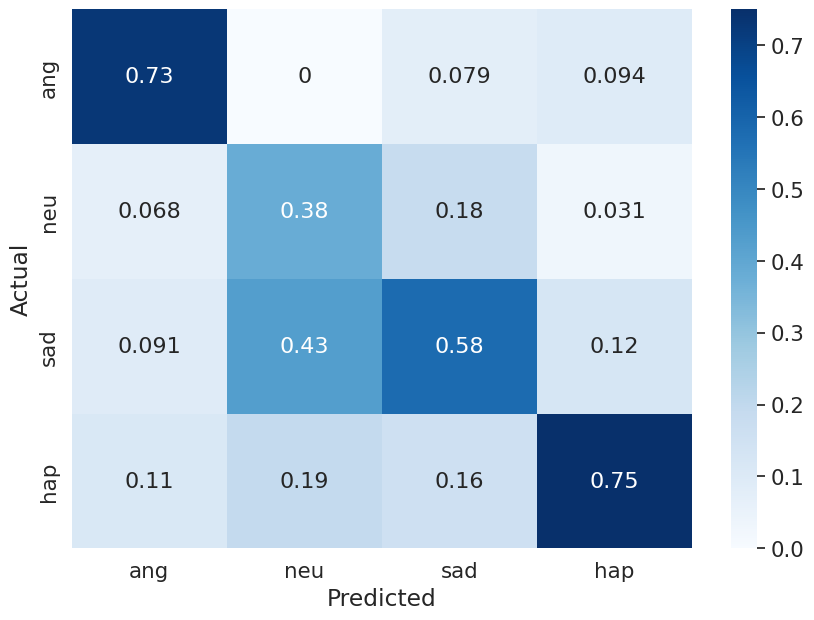

In [20]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

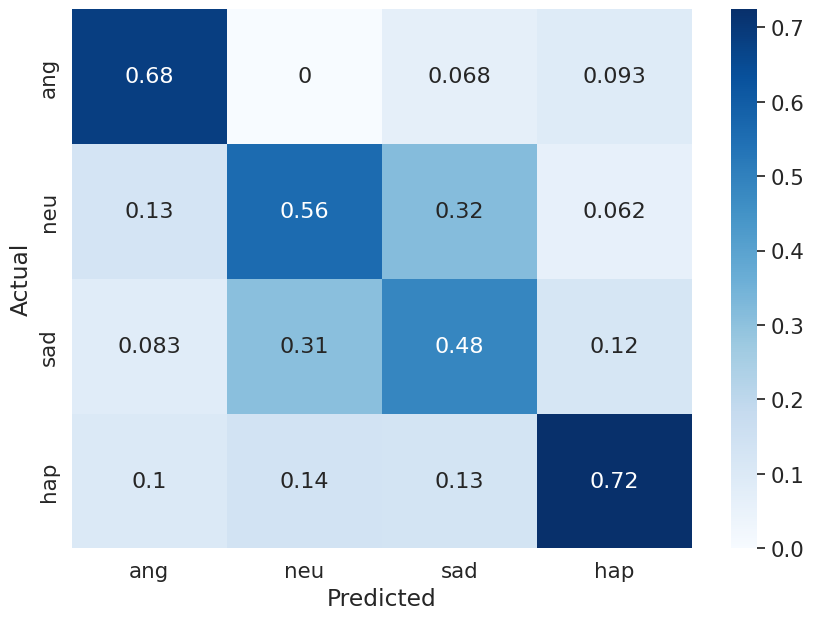

In [21]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [22]:
print(trainer.best_test_model_path)

../scb16_models/ravdess/run0model.epoch=61.step=6100.test_acc=0.6444.pt


In [24]:
me = {'acc_unweighted': torch.tensor(0.6505),
 'acc_weighted': torch.tensor(0.6444),
 'f1s_unweighted': torch.tensor(0.6348),
 'f1s_weighted': torch.tensor(0.6441),
 'rocauc': torch.tensor(0.8590),
 'uar': torch.tensor(0.6505),
 'wap': torch.tensor(0.6522)}
med = {'acc_detail': torch.tensor([0.7895, 0.6842, 0.5128, 0.6154]),
 'f1s_detail': torch.tensor([0.7792, 0.5652, 0.5634, 0.6316]),
 'precision_detail': torch.tensor([0.7692, 0.4815, 0.6250, 0.6486]),
 'recall_detail': torch.tensor([0.7895, 0.6842, 0.5128, 0.6154]),
 'rocauc_detail': torch.tensor([0.9343, 0.8875, 0.8038, 0.8102])}

cm = torch.tensor([[30,  1,  2,  5],
        [ 0, 13,  4,  2],
        [ 4,  9, 20,  6],
        [ 5,  4,  6, 24]])

<Axes: xlabel='Predicted', ylabel='Actual'>

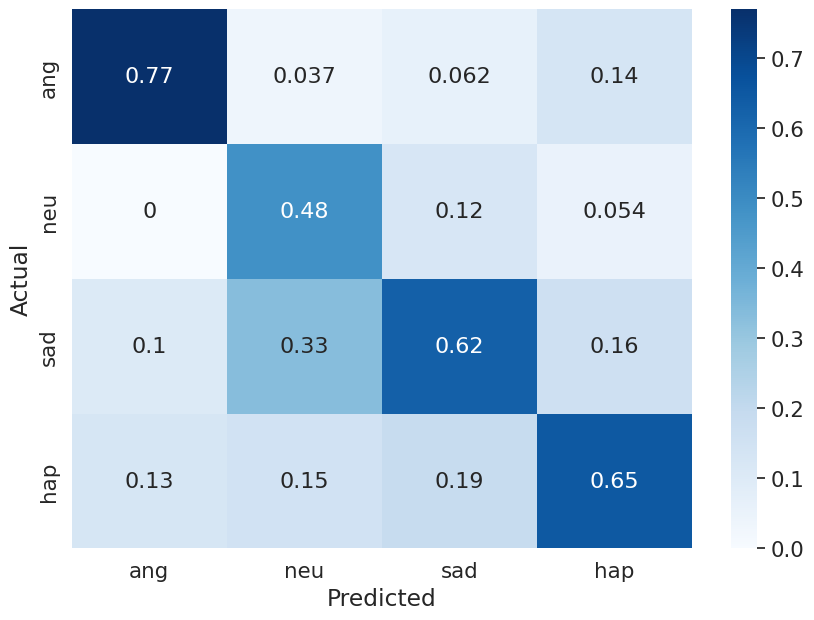

In [25]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

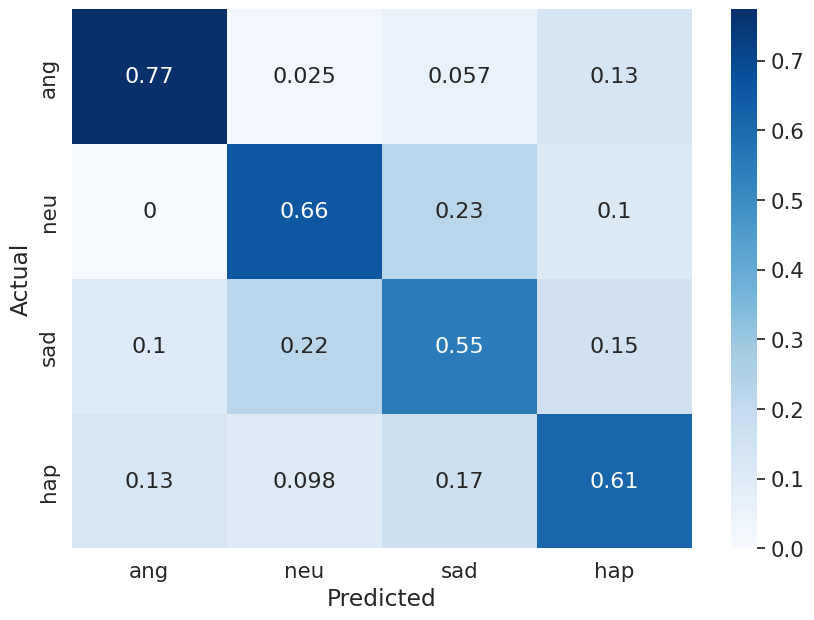

In [26]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [27]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

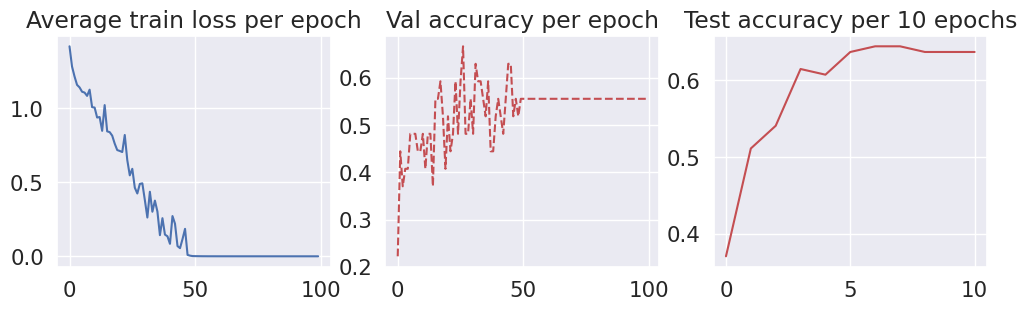

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

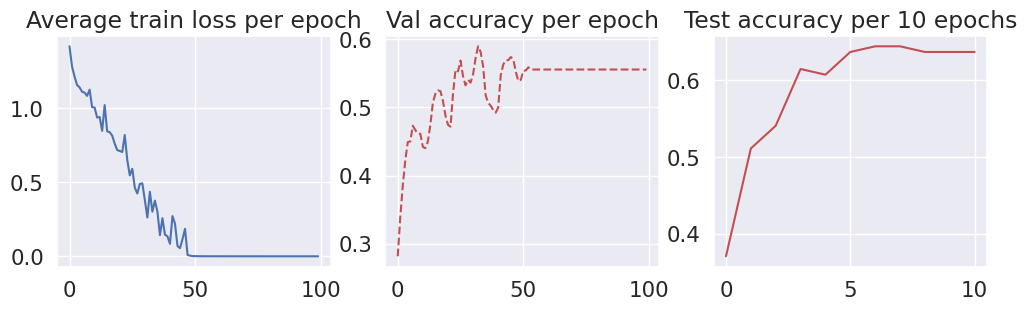

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

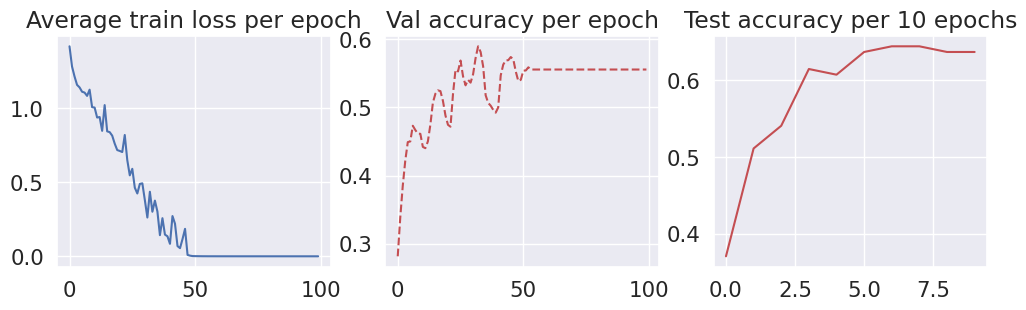

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [31]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_test_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

## run1

In [32]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run1/'
trainer.log_dir = log_dir

In [33]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512,], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [34]:
codebook_pretrained_path = f'../scb7_models/ravdess/codebook.step=10000.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [35]:
trainer.setup(model=model, lr=learning_rate)

In [36]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▍                                                                                  | 0.4927536231884051/100 [00:44<6:27:48, 233.83s/it]

Epoch: 1	Loss: 1.214 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.214]	Val_acc: 9/27 (33.33%)

Saved new best val model: ../scb16_models/ravdess/run1/model.epoch=1.step=51.loss=1.214.val_acc=0.333.pt


  1%|█                                                                                    | 1.297101449275365/100 [01:42<1:23:56, 51.03s/it]

Correct: 61/135 (0.4519)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=1.step=100.test_acc=0.4519.pt
{'acc_unweighted': tensor(0.3959, device='cuda:0'),
 'acc_weighted': tensor(0.4519, device='cuda:0'),
 'f1s_unweighted': tensor(0.2916, device='cuda:0'),
 'f1s_weighted': tensor(0.3322, device='cuda:0'),
 'rocauc': tensor(0.7871, device='cuda:0'),
 'uar': tensor(0.3959, device='cuda:0'),
 'wap': tensor(0.2668, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.0000, 0.8205, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.6374, 0.0000, 0.5289, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.5472, 0.0000, 0.3902, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.0000, 0.8205, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.8744, 0.7772, 0.7537, 0.7431], device='cuda:0')}
tensor([[29,  0,  9,  0],
        [ 0,  0, 19,  0],
        [ 7,  0, 32,  0],
        [17,  0, 22,  0]], device='cuda:0')


  2%|█▌                                                                                  | 1.789855072463773/100 [02:28<6:32:47, 239.97s/it]

Epoch: 2	Loss: 1.256 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.256]	Val_acc: 14/27 (51.85%)

Saved new best val model: ../scb16_models/ravdess/run1/model.epoch=2.step=151.loss=1.256.val_acc=0.519.pt


  3%|██▎                                                                                | 2.7608695652174005/100 [03:55<6:34:38, 243.50s/it]

Epoch: 3	Loss: 1.181 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.181]	Val_acc: 13/27 (48.15%)



  4%|███▏                                                                                | 3.731884057971028/100 [05:22<6:30:13, 243.21s/it]

Epoch: 4	Loss: 1.078 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.078]	Val_acc: 12/27 (44.44%)



  5%|███▉                                                                                | 4.702898550724612/100 [06:50<6:26:26, 243.31s/it]

Epoch: 5	Loss: 0.520 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.520]	Val_acc: 14/27 (51.85%)



  6%|████▊                                                                                | 5.67391304347818/100 [08:16<6:16:33, 239.52s/it]

Epoch: 6	Loss: 1.418 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.418]	Val_acc: 14/27 (51.85%)



  7%|█████▌                                                                              | 6.644927536231748/100 [09:43<6:15:45, 241.51s/it]

Epoch: 7	Loss: 1.230 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.230]	Val_acc: 15/27 (55.56%)

Saved new best val model: ../scb16_models/ravdess/run1/model.epoch=7.step=651.loss=1.230.val_acc=0.556.pt


  8%|██████▍                                                                             | 7.615942028985316/100 [11:10<6:19:32, 246.49s/it]

Epoch: 8	Loss: 0.607 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.607]	Val_acc: 12/27 (44.44%)



  9%|███████▏                                                                            | 8.586956521738884/100 [12:38<6:08:23, 241.80s/it]

Epoch: 9	Loss: 0.857 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.857]	Val_acc: 13/27 (48.15%)



 10%|████████                                                                            | 9.557971014492452/100 [14:06<6:01:11, 239.62s/it]

Epoch: 10	Loss: 1.372 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.372]	Val_acc: 14/27 (51.85%)



 11%|████████▊                                                                           | 10.52898550724602/100 [15:33<5:56:44, 239.23s/it]

Epoch: 11	Loss: 1.713 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.713]	Val_acc: 13/27 (48.15%)



 11%|█████████▋                                                                           | 11.33333333333293/100 [16:31<1:15:30, 51.10s/it]

Correct: 70/135 (0.5185)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=11.step=1100.test_acc=0.5185.pt
{'acc_unweighted': tensor(0.4585, device='cuda:0'),
 'acc_weighted': tensor(0.5185, device='cuda:0'),
 'f1s_unweighted': tensor(0.4414, device='cuda:0'),
 'f1s_weighted': tensor(0.4933, device='cuda:0'),
 'rocauc': tensor(0.8405, device='cuda:0'),
 'uar': tensor(0.4585, device='cuda:0'),
 'wap': tensor(0.5365, device='cuda:0')}
{'acc_detail': tensor([0.4737, 0.0526, 0.4872, 0.8205], device='cuda:0'),
 'f1s_detail': tensor([0.5902, 0.0833, 0.5205, 0.5714], device='cuda:0'),
 'precision_detail': tensor([0.7826, 0.2000, 0.5588, 0.4384], device='cuda:0'),
 'recall_detail': tensor([0.4737, 0.0526, 0.4872, 0.8205], device='cuda:0'),
 'rocauc_detail': tensor([0.9075, 0.8607, 0.8013, 0.7925], device='cuda:0')}
tensor([[18,  0,  2, 18],
        [ 0,  1,  9,  9],
        [ 4,  2, 19, 14],
        [ 1,  2,  4, 32]], device='cuda:0')


 12%|█████████▊                                                                         | 11.826086956521308/100 [17:17<5:55:01, 241.59s/it]

Epoch: 12	Loss: 0.184 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.184]	Val_acc: 13/27 (48.15%)



 13%|██████████▌                                                                        | 12.797101449274876/100 [18:45<5:50:30, 241.17s/it]

Epoch: 13	Loss: 0.704 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.704]	Val_acc: 12/27 (44.44%)



 14%|███████████▍                                                                       | 13.768115942028444/100 [20:12<5:47:59, 242.13s/it]

Epoch: 14	Loss: 0.611 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.611]	Val_acc: 15/27 (55.56%)



 15%|████████████▏                                                                      | 14.739130434782012/100 [21:39<5:46:42, 243.99s/it]

Epoch: 15	Loss: 0.266 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.266]	Val_acc: 13/27 (48.15%)



 16%|█████████████▏                                                                      | 15.71014492753558/100 [23:07<5:38:26, 240.91s/it]

Epoch: 16	Loss: 0.382 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.382]	Val_acc: 13/27 (48.15%)



 17%|██████████████                                                                      | 16.68115942028915/100 [24:34<5:33:42, 240.31s/it]

Epoch: 17	Loss: 0.387 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.387]	Val_acc: 14/27 (51.85%)



 18%|██████████████▋                                                                    | 17.652173913042716/100 [26:02<5:31:08, 241.27s/it]

Epoch: 18	Loss: 0.767 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.767]	Val_acc: 13/27 (48.15%)



 19%|███████████████▍                                                                   | 18.623188405796284/100 [27:29<5:30:29, 243.67s/it]

Epoch: 19	Loss: 0.221 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.221]	Val_acc: 15/27 (55.56%)



 20%|████████████████▎                                                                  | 19.594202898549852/100 [28:57<5:23:22, 241.31s/it]

Epoch: 20	Loss: 0.322 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.322]	Val_acc: 13/27 (48.15%)



 21%|█████████████████▎                                                                  | 20.56521739130342/100 [30:23<5:13:34, 236.86s/it]

Epoch: 21	Loss: 0.091 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.091]	Val_acc: 15/27 (55.56%)



 21%|██████████████████▏                                                                  | 21.36956521739033/100 [31:21<1:07:17, 51.35s/it]

Correct: 80/135 (0.5926)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=21.step=2100.test_acc=0.5926.pt
{'acc_unweighted': tensor(0.5982, device='cuda:0'),
 'acc_weighted': tensor(0.5926, device='cuda:0'),
 'f1s_unweighted': tensor(0.5879, device='cuda:0'),
 'f1s_weighted': tensor(0.5997, device='cuda:0'),
 'rocauc': tensor(0.8541, device='cuda:0'),
 'uar': tensor(0.5982, device='cuda:0'),
 'wap': tensor(0.6467, device='cuda:0')}
{'acc_detail': tensor([0.6842, 0.6316, 0.6410, 0.4359], device='cuda:0'),
 'f1s_detail': tensor([0.7536, 0.5000, 0.5495, 0.5484], device='cuda:0'),
 'precision_detail': tensor([0.8387, 0.4138, 0.4808, 0.7391], device='cuda:0'),
 'recall_detail': tensor([0.6842, 0.6316, 0.6410, 0.4359], device='cuda:0'),
 'rocauc_detail': tensor([0.9467, 0.8684, 0.8056, 0.7957], device='cuda:0')}
tensor([[26,  0, 10,  2],
        [ 0, 12,  5,  2],
        [ 2, 10, 25,  2],
        [ 3,  7, 12, 17]], device='cuda:0')


 22%|██████████████████▎                                                                 | 21.86231884057871/100 [32:08<5:13:14, 240.53s/it]

Epoch: 22	Loss: 0.024 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.024]	Val_acc: 16/27 (59.26%)

Saved new best val model: ../scb16_models/ravdess/run1/model.epoch=22.step=2151.loss=0.024.val_acc=0.593.pt


 23%|██████████████████▉                                                                | 22.833333333332277/100 [33:35<5:11:41, 242.35s/it]

Epoch: 23	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 24%|███████████████████▊                                                               | 23.804347826085845/100 [35:02<5:09:06, 243.40s/it]

Epoch: 24	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 15/27 (55.56%)



 25%|████████████████████▌                                                              | 24.775362318839413/100 [36:29<5:03:49, 242.34s/it]

Epoch: 25	Loss: 0.038 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.038]	Val_acc: 14/27 (51.85%)



 26%|█████████████████████▋                                                              | 25.74637681159298/100 [37:57<4:56:24, 239.51s/it]

Epoch: 26	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 15/27 (55.56%)



 27%|██████████████████████▍                                                             | 26.71739130434655/100 [39:24<4:54:40, 241.27s/it]

Epoch: 27	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 28%|██████████████████████▉                                                            | 27.688405797100117/100 [40:52<4:51:50, 242.16s/it]

Epoch: 28	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 14/27 (51.85%)



 29%|███████████████████████▊                                                           | 28.659420289853685/100 [42:19<4:42:21, 237.48s/it]

Epoch: 29	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 30%|████████████████████████▌                                                          | 29.630434782607253/100 [43:45<4:44:41, 242.74s/it]

Epoch: 30	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 31%|█████████████████████████▋                                                          | 30.60144927536082/100 [45:13<4:40:09, 242.21s/it]

Epoch: 31	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 31%|███████████████████████████▎                                                           | 31.40579710144773/100 [46:11<58:13, 50.93s/it]

Correct: 84/135 (0.6222)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=31.step=3100.test_acc=0.6222.pt
{'acc_unweighted': tensor(0.6311, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6142, device='cuda:0'),
 'f1s_weighted': tensor(0.6253, device='cuda:0'),
 'rocauc': tensor(0.8584, device='cuda:0'),
 'uar': tensor(0.6311, device='cuda:0'),
 'wap': tensor(0.6401, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5128, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7838, 0.5306, 0.5634, 0.5789], device='cuda:0'),
 'precision_detail': tensor([0.8056, 0.4333, 0.6250, 0.5946], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5128, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9517, 0.8816, 0.8240, 0.7764], device='cuda:0')}
tensor([[29,  0,  3,  6],
        [ 0, 13,  2,  4],
        [ 3, 11, 20,  5],
        [ 4,  6,  7, 22]], device='cuda:0')


 32%|██████████████████████████▊                                                         | 31.89855072463611/100 [46:57<4:34:31, 241.86s/it]

Epoch: 32	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 33%|███████████████████████████▌                                                        | 32.86956521738968/100 [48:25<4:33:12, 244.19s/it]

Epoch: 33	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 34%|████████████████████████████                                                       | 33.840579710143246/100 [49:52<4:27:53, 242.95s/it]

Epoch: 34	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 35%|█████████████████████████████▏                                                      | 34.81159420289681/100 [51:19<4:23:20, 242.38s/it]

Epoch: 35	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 36%|██████████████████████████████                                                      | 35.78260869565038/100 [52:47<4:28:50, 251.18s/it]

Epoch: 36	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 37%|██████████████████████████████▊                                                     | 36.75362318840395/100 [54:16<4:20:19, 246.96s/it]

Epoch: 37	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 38%|███████████████████████████████▋                                                    | 37.72463768115752/100 [55:45<4:11:45, 242.57s/it]

Epoch: 38	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 39%|████████████████████████████████                                                   | 38.695652173911085/100 [57:14<4:09:13, 243.92s/it]

Epoch: 39	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 40%|█████████████████████████████████▎                                                  | 39.66666666666465/100 [58:43<4:05:08, 243.78s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 41%|█████████████████████████████████▎                                                | 40.63768115941822/100 [1:00:12<4:03:23, 246.01s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 41%|███████████████████████████████████▏                                                 | 41.44202898550513/100 [1:01:11<50:27, 51.69s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6311, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6142, device='cuda:0'),
 'f1s_weighted': tensor(0.6268, device='cuda:0'),
 'rocauc': tensor(0.8550, device='cuda:0'),
 'uar': tensor(0.6311, device='cuda:0'),
 'wap': tensor(0.6446, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6842, 0.5128, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7945, 0.5200, 0.5634, 0.5789], device='cuda:0'),
 'precision_detail': tensor([0.8286, 0.4194, 0.6250, 0.5946], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6842, 0.5128, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9523, 0.8800, 0.8138, 0.7738], device='cuda:0')}
tensor([[29,  0,  3,  6],
        [ 0, 13,  2,  4],
        [ 3, 11, 20,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 42%|██████████████████████████████████▍                                               | 41.93478260869351/100 [1:01:59<3:56:32, 244.42s/it]

Epoch: 42	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 43%|███████████████████████████████████▏                                              | 42.90579710144708/100 [1:03:27<3:54:50, 246.79s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 44%|███████████████████████████████████▌                                             | 43.876811594200646/100 [1:04:57<3:49:46, 245.64s/it]

Epoch: 44	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 45%|████████████████████████████████████▎                                            | 44.847826086954214/100 [1:06:26<3:44:40, 244.42s/it]

Epoch: 45	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 46%|█████████████████████████████████████▌                                            | 45.81884057970778/100 [1:07:54<3:36:53, 240.18s/it]

Epoch: 46	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 47%|██████████████████████████████████████▎                                           | 46.78985507246135/100 [1:09:22<3:33:36, 240.86s/it]

Epoch: 47	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 16/27 (59.26%)



 48%|███████████████████████████████████████▏                                          | 47.76086956521492/100 [1:10:49<3:28:31, 239.49s/it]

Epoch: 48	Loss: 1.242 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.242]	Val_acc: 13/27 (48.15%)



 49%|███████████████████████████████████████▍                                         | 48.731884057968486/100 [1:12:16<3:27:51, 243.26s/it]

Epoch: 49	Loss: 0.022 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.022]	Val_acc: 19/27 (70.37%)

Saved new best val model: ../scb16_models/ravdess/run1/model.epoch=49.step=4851.loss=0.022.val_acc=0.704.pt


 50%|████████████████████████████████████████▎                                        | 49.702898550722054/100 [1:13:43<3:20:10, 238.79s/it]

Epoch: 50	Loss: 0.089 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.089]	Val_acc: 19/27 (70.37%)



 51%|█████████████████████████████████████████▌                                        | 50.67391304347562/100 [1:15:11<3:20:30, 243.89s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 51%|███████████████████████████████████████████▊                                         | 51.47826086956253/100 [1:16:09<41:09, 50.90s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6036, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6030, device='cuda:0'),
 'f1s_weighted': tensor(0.6292, device='cuda:0'),
 'rocauc': tensor(0.8597, device='cuda:0'),
 'uar': tensor(0.6036, device='cuda:0'),
 'wap': tensor(0.6441, device='cuda:0')}
{'acc_detail': tensor([0.6842, 0.4737, 0.6667, 0.5897], device='cuda:0'),
 'f1s_detail': tensor([0.7536, 0.4186, 0.6265, 0.6133], device='cuda:0'),
 'precision_detail': tensor([0.8387, 0.3750, 0.5909, 0.6389], device='cuda:0'),
 'recall_detail': tensor([0.6842, 0.4737, 0.6667, 0.5897], device='cuda:0'),
 'rocauc_detail': tensor([0.9495, 0.8816, 0.8431, 0.7647], device='cuda:0')}
tensor([[26,  0,  4,  8],
        [ 0,  9,  6,  4],
        [ 2, 10, 26,  1],
        [ 3,  5,  8, 23]], device='cuda:0')


 52%|██████████████████████████████████████████▌                                       | 51.97101449275091/100 [1:16:55<3:12:38, 240.65s/it]

Epoch: 52	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 14/27 (51.85%)



 53%|███████████████████████████████████████████▍                                      | 52.94202898550448/100 [1:18:22<3:09:06, 241.13s/it]

Epoch: 53	Loss: 0.017 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.017]	Val_acc: 15/27 (55.56%)



 54%|████████████████████████████████████████████▏                                     | 53.91304347825805/100 [1:19:49<3:06:55, 243.36s/it]

Epoch: 54	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 55%|████████████████████████████████████████████▍                                    | 54.884057971011615/100 [1:21:17<3:00:26, 239.98s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 56%|█████████████████████████████████████████████▊                                    | 55.85507246376518/100 [1:22:44<2:56:22, 239.73s/it]

Epoch: 56	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 57%|██████████████████████████████████████████████▌                                   | 56.82608695651875/100 [1:24:12<2:51:24, 238.21s/it]

Epoch: 57	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 58%|███████████████████████████████████████████████▍                                  | 57.79710144927232/100 [1:25:39<2:49:45, 241.35s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 59%|████████████████████████████████████████████████▏                                 | 58.76811594202589/100 [1:27:06<2:44:02, 238.72s/it]

Epoch: 59	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 60%|████████████████████████████████████████████████▍                                | 59.739130434779455/100 [1:28:33<2:41:08, 240.16s/it]

Epoch: 60	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 61%|█████████████████████████████████████████████████▊                                | 60.71014492753302/100 [1:30:01<2:36:52, 239.57s/it]

Epoch: 61	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 15/27 (55.56%)



 62%|████████████████████████████████████████████████████▎                                | 61.51449275361993/100 [1:30:59<32:37, 50.87s/it]

Correct: 83/135 (0.6148)
{'acc_unweighted': tensor(0.6378, device='cuda:0'),
 'acc_weighted': tensor(0.6148, device='cuda:0'),
 'f1s_unweighted': tensor(0.6132, device='cuda:0'),
 'f1s_weighted': tensor(0.6175, device='cuda:0'),
 'rocauc': tensor(0.8630, device='cuda:0'),
 'uar': tensor(0.6378, device='cuda:0'),
 'wap': tensor(0.6375, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5769, 0.5479, 0.5676], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4545, 0.5882, 0.6000], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9512, 0.8945, 0.8365, 0.7698], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 15,  3,  1],
        [ 3, 10, 20,  6],
        [ 3,  7,  8, 21]], device='cuda:0')


 62%|██████████████████████████████████████████████████▊                               | 62.00724637680831/100 [1:31:45<2:32:07, 240.24s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 63%|███████████████████████████████████████████████████▋                              | 62.97826086956188/100 [1:33:13<2:32:11, 246.65s/it]

Epoch: 63	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 64%|████████████████████████████████████████████████████▍                             | 63.94927536231545/100 [1:34:42<2:24:12, 240.00s/it]

Epoch: 64	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 65%|█████████████████████████████████████████████████████▏                            | 64.92028985506902/100 [1:36:09<2:20:13, 239.84s/it]

Epoch: 65	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 66%|██████████████████████████████████████████████████████                            | 65.89130434782258/100 [1:37:37<2:16:49, 240.68s/it]

Epoch: 66	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 67%|██████████████████████████████████████████████████████▊                           | 66.86231884057615/100 [1:39:04<2:13:16, 241.32s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 68%|███████████████████████████████████████████████████████▌                          | 67.83333333332972/100 [1:40:32<2:10:05, 242.66s/it]

Epoch: 68	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 69%|████████████████████████████████████████████████████████▍                         | 68.80434782608329/100 [1:42:00<2:05:07, 240.66s/it]

Epoch: 69	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 70%|█████████████████████████████████████████████████████████▏                        | 69.77536231883686/100 [1:43:28<2:01:10, 240.54s/it]

Epoch: 70	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 71%|██████████████████████████████████████████████████████████                        | 70.74637681159042/100 [1:44:54<1:56:42, 239.38s/it]

Epoch: 71	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 72%|████████████████████████████████████████████████████████████▊                        | 71.55072463767733/100 [1:45:53<24:08, 50.92s/it]

Correct: 83/135 (0.6148)
{'acc_unweighted': tensor(0.6378, device='cuda:0'),
 'acc_weighted': tensor(0.6148, device='cuda:0'),
 'f1s_unweighted': tensor(0.6132, device='cuda:0'),
 'f1s_weighted': tensor(0.6175, device='cuda:0'),
 'rocauc': tensor(0.8629, device='cuda:0'),
 'uar': tensor(0.6378, device='cuda:0'),
 'wap': tensor(0.6375, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5769, 0.5479, 0.5676], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4545, 0.5882, 0.6000], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9516, 0.8927, 0.8343, 0.7730], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 15,  3,  1],
        [ 3, 10, 20,  6],
        [ 3,  7,  8, 21]], device='cuda:0')


 72%|███████████████████████████████████████████████████████████                       | 72.04347826086571/100 [1:46:39<1:51:23, 239.08s/it]

Epoch: 72	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 72%|█████████████████████████████████████████████████████████████▍                       | 72.21739130434396/100 [1:46:54<40:01, 86.43s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7572eae31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7572eae31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 72%|█████████████████████████████████████████████████████████████▍                       | 72.22463768115556/100 [1:46:54<41:06, 88.82s/i

RuntimeError: DataLoader worker (pid(s) 3028424, 3028432, 3028440, 3028448, 3028456, 3028464, 3028472, 3028480) exited unexpectedly

In [37]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/ravdess/run1/model.epoch=49.step=4851.loss=0.022.val_acc=0.704.pt


In [38]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 80/135 (0.5926)


In [39]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.6120),
 'acc_weighted': tensor(0.5926),
 'f1s_unweighted': tensor(0.5707),
 'f1s_weighted': tensor(0.5784),
 'rocauc': tensor(0.8477),
 'uar': tensor(0.6120),
 'wap': tensor(0.7152)}
{'acc_detail': tensor([0.7368, 0.7368, 0.7179, 0.2564]),
 'f1s_detail': tensor([0.7568, 0.5091, 0.6087, 0.4082]),
 'precision_detail': tensor([0.7778, 0.3889, 0.5283, 1.0000]),
 'recall_detail': tensor([0.7368, 0.7368, 0.7179, 0.2564]),
 'rocauc_detail': tensor([0.9323, 0.8625, 0.8130, 0.7831])}
tensor([[28,  2,  8,  0],
        [ 0, 14,  5,  0],
        [ 1, 10, 28,  0],
        [ 7, 10, 12, 10]])


In [41]:
trainer.load(log_dir + "model.epoch=71.step=7100.pt")

In [42]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 83/135 (0.6148)


In [43]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.6378),
 'acc_weighted': tensor(0.6148),
 'f1s_unweighted': tensor(0.6132),
 'f1s_weighted': tensor(0.6175),
 'rocauc': tensor(0.8629),
 'uar': tensor(0.6378),
 'wap': tensor(0.6375)}
{'acc_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385]),
 'f1s_detail': tensor([0.7606, 0.5769, 0.5479, 0.5676]),
 'precision_detail': tensor([0.8182, 0.4545, 0.5882, 0.6000]),
 'recall_detail': tensor([0.7105, 0.7895, 0.5128, 0.5385]),
 'rocauc_detail': tensor([0.9516, 0.8927, 0.8343, 0.7730])}
tensor([[27,  1,  3,  7],
        [ 0, 15,  3,  1],
        [ 3, 10, 20,  6],
        [ 3,  7,  8, 21]])


In [44]:
trainer.fit(n_epoch=20, self_supervised=False, train_task='embedding', test_n_epoch=1)

  2%|█▌                                                                                  | 0.3798882681564243/20 [00:45<1:42:22, 313.08s/it]

Epoch: 73	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



  5%|████▍                                                                                   | 1.000000000000004/20 [01:43<21:19, 67.35s/it]

Correct: 81/135 (0.6000)
{'acc_unweighted': tensor(0.6048, device='cuda:0'),
 'acc_weighted': tensor(0.6000, device='cuda:0'),
 'f1s_unweighted': tensor(0.5940, device='cuda:0'),
 'f1s_weighted': tensor(0.6051, device='cuda:0'),
 'rocauc': tensor(0.8635, device='cuda:0'),
 'uar': tensor(0.6048, device='cuda:0'),
 'wap': tensor(0.6194, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.6316, 0.5128, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5106, 0.5479, 0.5570], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4286, 0.5882, 0.5500], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.6316, 0.5128, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9510, 0.8945, 0.8329, 0.7754], device='cuda:0')}
tensor([[27,  0,  2,  9],
        [ 0, 12,  5,  2],
        [ 3,  9, 20,  7],
        [ 3,  7,  7, 22]], device='cuda:0')


  7%|█████▊                                                                               | 1.379888268156432/20 [02:30<1:36:49, 311.97s/it]

Epoch: 74	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 16/27 (59.26%)



 10%|████████▊                                                                               | 2.000000000000013/20 [03:29<20:12, 67.37s/it]

Correct: 85/135 (0.6296)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=74.step=7369.test_acc=0.6296.pt
{'acc_unweighted': tensor(0.6574, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6288, device='cuda:0'),
 'f1s_weighted': tensor(0.6315, device='cuda:0'),
 'rocauc': tensor(0.8615, device='cuda:0'),
 'uar': tensor(0.6574, device='cuda:0'),
 'wap': tensor(0.6534, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.8421, 0.5385, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.6038, 0.5753, 0.5753], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4706, 0.6176, 0.6176], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.8421, 0.5385, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9509, 0.8931, 0.8363, 0.7658], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 16,  2,  1],
        [ 3, 10, 21,  5],
        [ 3,  7,  8, 21]], device='cuda:0')


 12%|██████████                                                                           | 2.379888268156441/20 [04:15<1:32:24, 314.67s/it]

Epoch: 75	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 15%|█████████████                                                                          | 3.0000000000000218/20 [05:15<19:03, 67.29s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6508, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6257, device='cuda:0'),
 'f1s_weighted': tensor(0.6319, device='cuda:0'),
 'rocauc': tensor(0.8613, device='cuda:0'),
 'uar': tensor(0.6508, device='cuda:0'),
 'wap': tensor(0.6514, device='cuda:0')}
{'acc_detail': tensor([0.7368, 0.7895, 0.5385, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7671, 0.5769, 0.5753, 0.5833], device='cuda:0'),
 'precision_detail': tensor([0.8000, 0.4545, 0.6176, 0.6364], device='cuda:0'),
 'recall_detail': tensor([0.7368, 0.7895, 0.5385, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9512, 0.8920, 0.8339, 0.7682], device='cuda:0')}
tensor([[28,  1,  4,  5],
        [ 0, 15,  2,  2],
        [ 3, 10, 21,  5],
        [ 4,  7,  7, 21]], device='cuda:0')


 17%|██████████████▏                                                                     | 3.3798882681564497/20 [06:01<1:28:50, 320.73s/it]

Epoch: 76	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 20%|█████████████████▊                                                                       | 4.00000000000003/20 [07:01<17:54, 67.19s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6506, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6269, device='cuda:0'),
 'f1s_weighted': tensor(0.6333, device='cuda:0'),
 'rocauc': tensor(0.8615, device='cuda:0'),
 'uar': tensor(0.6506, device='cuda:0'),
 'wap': tensor(0.6547, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7895, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5769, 0.5833, 0.5867], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4545, 0.6364, 0.6111], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7895, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9520, 0.8943, 0.8331, 0.7666], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 15,  2,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 22%|██████████████████▌                                                                  | 4.379888268156458/20 [07:47<1:20:37, 309.73s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 25%|██████████████████████                                                                  | 5.000000000000039/20 [08:46<16:40, 66.67s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6375, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6179, device='cuda:0'),
 'f1s_weighted': tensor(0.6270, device='cuda:0'),
 'rocauc': tensor(0.8617, device='cuda:0'),
 'uar': tensor(0.6375, device='cuda:0'),
 'wap': tensor(0.6469, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5490, 0.5753, 0.5867], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4375, 0.6176, 0.6111], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9523, 0.8929, 0.8336, 0.7682], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 14,  3,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 27%|██████████████████████▊                                                              | 5.379888268156467/20 [09:33<1:17:03, 316.21s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 30%|██████████████████████████▍                                                             | 6.000000000000048/20 [10:31<15:29, 66.42s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6506, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6269, device='cuda:0'),
 'f1s_weighted': tensor(0.6333, device='cuda:0'),
 'rocauc': tensor(0.8616, device='cuda:0'),
 'uar': tensor(0.6506, device='cuda:0'),
 'wap': tensor(0.6547, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7895, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5769, 0.5833, 0.5867], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4545, 0.6364, 0.6111], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7895, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9525, 0.8931, 0.8324, 0.7684], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 15,  2,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 32%|███████████████████████████                                                          | 6.379888268156476/20 [11:18<1:11:45, 316.12s/it]

Epoch: 79	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 35%|██████████████████████████████▊                                                         | 7.000000000000057/20 [12:17<14:24, 66.51s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6441, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6243, device='cuda:0'),
 'f1s_weighted': tensor(0.6343, device='cuda:0'),
 'rocauc': tensor(0.8612, device='cuda:0'),
 'uar': tensor(0.6441, device='cuda:0'),
 'wap': tensor(0.6536, device='cuda:0')}
{'acc_detail': tensor([0.7368, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7778, 0.5490, 0.5676, 0.6027], device='cuda:0'),
 'precision_detail': tensor([0.8235, 0.4375, 0.6000, 0.6471], device='cuda:0'),
 'recall_detail': tensor([0.7368, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9531, 0.8918, 0.8316, 0.7682], device='cuda:0')}
tensor([[28,  1,  4,  5],
        [ 0, 14,  3,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 37%|███████████████████████████████▎                                                     | 7.379888268156485/20 [13:03<1:07:08, 319.22s/it]

Epoch: 80	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 40%|███████████████████████████████████▏                                                    | 8.000000000000066/20 [14:02<13:21, 66.83s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6441, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6243, device='cuda:0'),
 'f1s_weighted': tensor(0.6343, device='cuda:0'),
 'rocauc': tensor(0.8607, device='cuda:0'),
 'uar': tensor(0.6441, device='cuda:0'),
 'wap': tensor(0.6536, device='cuda:0')}
{'acc_detail': tensor([0.7368, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7778, 0.5490, 0.5676, 0.6027], device='cuda:0'),
 'precision_detail': tensor([0.8235, 0.4375, 0.6000, 0.6471], device='cuda:0'),
 'recall_detail': tensor([0.7368, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9504, 0.8929, 0.8309, 0.7684], device='cuda:0')}
tensor([[28,  1,  4,  5],
        [ 0, 14,  3,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 42%|███████████████████████████████████▌                                                 | 8.379888268156494/20 [14:48<1:00:54, 314.48s/it]

Epoch: 81	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 45%|███████████████████████████████████████▌                                                | 9.000000000000075/20 [15:47<12:10, 66.40s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6377, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6168, device='cuda:0'),
 'f1s_weighted': tensor(0.6257, device='cuda:0'),
 'rocauc': tensor(0.8604, device='cuda:0'),
 'uar': tensor(0.6377, device='cuda:0'),
 'wap': tensor(0.6439, device='cuda:0')}
{'acc_detail': tensor([0.7368, 0.7368, 0.5385, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7671, 0.5490, 0.5676, 0.5833], device='cuda:0'),
 'precision_detail': tensor([0.8000, 0.4375, 0.6000, 0.6364], device='cuda:0'),
 'recall_detail': tensor([0.7368, 0.7368, 0.5385, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9504, 0.8920, 0.8299, 0.7694], device='cuda:0')}
tensor([[28,  1,  4,  5],
        [ 0, 14,  3,  2],
        [ 3, 10, 21,  5],
        [ 4,  7,  7, 21]], device='cuda:0')


 47%|████████████████████████████████████████▊                                              | 9.379888268156503/20 [16:33<55:23, 312.95s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 50%|███████████████████████████████████████████▌                                           | 10.000000000000083/20 [17:32<11:01, 66.17s/it]

Correct: 84/135 (0.6222)
{'acc_unweighted': tensor(0.6375, device='cuda:0'),
 'acc_weighted': tensor(0.6222, device='cuda:0'),
 'f1s_unweighted': tensor(0.6179, device='cuda:0'),
 'f1s_weighted': tensor(0.6270, device='cuda:0'),
 'rocauc': tensor(0.8604, device='cuda:0'),
 'uar': tensor(0.6375, device='cuda:0'),
 'wap': tensor(0.6469, device='cuda:0')}
{'acc_detail': tensor([0.7105, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7606, 0.5490, 0.5753, 0.5867], device='cuda:0'),
 'precision_detail': tensor([0.8182, 0.4375, 0.6176, 0.6111], device='cuda:0'),
 'recall_detail': tensor([0.7105, 0.7368, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9518, 0.8934, 0.8307, 0.7658], device='cuda:0')}
tensor([[27,  1,  3,  7],
        [ 0, 14,  3,  2],
        [ 3, 10, 21,  5],
        [ 3,  7,  7, 22]], device='cuda:0')


 52%|████████████████████████████████████████████▋                                         | 10.379888268156511/20 [18:18<51:22, 320.46s/it]

Epoch: 83	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 18/27 (66.67%)



 55%|███████████████████████████████████████████████▊                                       | 11.000000000000092/20 [19:17<10:03, 67.08s/it]

Correct: 79/135 (0.5852)
{'acc_unweighted': tensor(0.5911, device='cuda:0'),
 'acc_weighted': tensor(0.5852, device='cuda:0'),
 'f1s_unweighted': tensor(0.5809, device='cuda:0'),
 'f1s_weighted': tensor(0.5871, device='cuda:0'),
 'rocauc': tensor(0.8239, device='cuda:0'),
 'uar': tensor(0.5911, device='cuda:0'),
 'wap': tensor(0.6395, device='cuda:0')}
{'acc_detail': tensor([0.5789, 0.6316, 0.7436, 0.4103], device='cuda:0'),
 'f1s_detail': tensor([0.6984, 0.5333, 0.5918, 0.5000], device='cuda:0'),
 'precision_detail': tensor([0.8800, 0.4615, 0.4915, 0.6400], device='cuda:0'),
 'recall_detail': tensor([0.5789, 0.6316, 0.7436, 0.4103], device='cuda:0'),
 'rocauc_detail': tensor([0.9224, 0.8748, 0.7946, 0.7039], device='cuda:0')}
tensor([[22,  1,  9,  6],
        [ 0, 12,  7,  0],
        [ 0,  7, 29,  3],
        [ 3,  6, 14, 16]], device='cuda:0')


 57%|█████████████████████████████████████████████████▌                                     | 11.37988826815652/20 [20:03<45:37, 317.56s/it]

Epoch: 84	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 60%|████████████████████████████████████████████████████▏                                  | 12.000000000000101/20 [21:03<08:55, 66.98s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6646, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6219, device='cuda:0'),
 'f1s_weighted': tensor(0.6289, device='cuda:0'),
 'rocauc': tensor(0.8533, device='cuda:0'),
 'uar': tensor(0.6646, device='cuda:0'),
 'wap': tensor(0.6761, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.8947, 0.4872, 0.4872], device='cuda:0'),
 'f1s_detail': tensor([0.7692, 0.5667, 0.5758, 0.5758], device='cuda:0'),
 'precision_detail': tensor([0.7500, 0.4146, 0.7037, 0.7037], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.8947, 0.4872, 0.4872], device='cuda:0'),
 'rocauc_detail': tensor([0.9487, 0.8827, 0.8145, 0.7674], device='cuda:0')}
tensor([[30,  2,  2,  4],
        [ 0, 17,  1,  1],
        [ 6, 11, 19,  3],
        [ 4, 11,  5, 19]], device='cuda:0')


 62%|█████████████████████████████████████████████████████▊                                 | 12.37988826815653/20 [21:50<40:13, 316.70s/it]

Epoch: 85	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 65%|█████████████████████████████████████████████████████████▏                              | 13.00000000000011/20 [22:49<07:49, 67.00s/it]

Correct: 81/135 (0.6000)
{'acc_unweighted': tensor(0.5648, device='cuda:0'),
 'acc_weighted': tensor(0.6000, device='cuda:0'),
 'f1s_unweighted': tensor(0.5653, device='cuda:0'),
 'f1s_weighted': tensor(0.5953, device='cuda:0'),
 'rocauc': tensor(0.8552, device='cuda:0'),
 'uar': tensor(0.5648, device='cuda:0'),
 'wap': tensor(0.5949, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.3158, 0.5641, 0.5897], device='cuda:0'),
 'f1s_detail': tensor([0.7595, 0.3529, 0.5946, 0.5542], device='cuda:0'),
 'precision_detail': tensor([0.7317, 0.4000, 0.6286, 0.5227], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.3158, 0.5641, 0.5897], device='cuda:0'),
 'rocauc_detail': tensor([0.9398, 0.8827, 0.8323, 0.7660], device='cuda:0')}
tensor([[30,  0,  3,  5],
        [ 2,  6,  4,  7],
        [ 3,  5, 22,  9],
        [ 6,  4,  6, 23]], device='cuda:0')


 67%|█████████████████████████████████████████████████████████▌                            | 13.379888268156538/20 [23:35<35:07, 318.38s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 14/27 (51.85%)



 70%|████████████████████████████████████████████████████████████▉                          | 14.000000000000119/20 [24:34<06:41, 66.95s/it]

Correct: 82/135 (0.6074)
{'acc_unweighted': tensor(0.5972, device='cuda:0'),
 'acc_weighted': tensor(0.6074, device='cuda:0'),
 'f1s_unweighted': tensor(0.5961, device='cuda:0'),
 'f1s_weighted': tensor(0.6161, device='cuda:0'),
 'rocauc': tensor(0.8461, device='cuda:0'),
 'uar': tensor(0.5972, device='cuda:0'),
 'wap': tensor(0.6490, device='cuda:0')}
{'acc_detail': tensor([0.6316, 0.5263, 0.6923, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7385, 0.4545, 0.6000, 0.5915], device='cuda:0'),
 'precision_detail': tensor([0.8889, 0.4000, 0.5294, 0.6562], device='cuda:0'),
 'recall_detail': tensor([0.6316, 0.5263, 0.6923, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9391, 0.8686, 0.8263, 0.7504], device='cuda:0')}
tensor([[24,  1,  8,  5],
        [ 0, 10,  8,  1],
        [ 0,  7, 27,  5],
        [ 3,  7,  8, 21]], device='cuda:0')


 72%|█████████████████████████████████████████████████████████████▊                        | 14.379888268156547/20 [25:20<29:42, 317.15s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 15/27 (55.56%)



 75%|█████████████████████████████████████████████████████████████████▎                     | 15.000000000000128/20 [26:19<05:34, 66.88s/it]

Correct: 88/135 (0.6519)
Saved new best test model: ../scb16_models/ravdess/run1/model.epoch=87.step=8669.test_acc=0.6519.pt
{'acc_unweighted': tensor(0.6770, device='cuda:0'),
 'acc_weighted': tensor(0.6519, device='cuda:0'),
 'f1s_unweighted': tensor(0.6479, device='cuda:0'),
 'f1s_weighted': tensor(0.6550, device='cuda:0'),
 'rocauc': tensor(0.8560, device='cuda:0'),
 'uar': tensor(0.6770, device='cuda:0'),
 'wap': tensor(0.6833, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.8421, 0.5385, 0.5641], device='cuda:0'),
 'f1s_detail': tensor([0.7945, 0.5926, 0.6176, 0.5867], device='cuda:0'),
 'precision_detail': tensor([0.8286, 0.4571, 0.7241, 0.6111], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.8421, 0.5385, 0.5641], device='cuda:0'),
 'rocauc_detail': tensor([0.9452, 0.8902, 0.8221, 0.7663], device='cuda:0')}
tensor([[29,  1,  1,  7],
        [ 1, 16,  1,  1],
        [ 2, 10, 21,  6],
        [ 3,  8,  6, 22]], device='cuda:0')


 77%|██████████████████████████████████████████████████████████████████▏                   | 15.379888268156556/20 [27:06<24:23, 316.77s/it]

Epoch: 88	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 80%|█████████████████████████████████████████████████████████████████████▌                 | 16.000000000000135/20 [28:04<04:27, 66.83s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6240, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6177, device='cuda:0'),
 'f1s_weighted': tensor(0.6322, device='cuda:0'),
 'rocauc': tensor(0.8571, device='cuda:0'),
 'uar': tensor(0.6240, device='cuda:0'),
 'wap': tensor(0.6376, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.5789, 0.6154, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7838, 0.5116, 0.6154, 0.5600], device='cuda:0'),
 'precision_detail': tensor([0.8056, 0.4583, 0.6154, 0.5833], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.5789, 0.6154, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9490, 0.8879, 0.8277, 0.7636], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 1, 11,  4,  3],
        [ 2,  6, 24,  7],
        [ 4,  6,  8, 21]], device='cuda:0')


 82%|██████████████████████████████████████████████████████████████████████▍               | 16.379888268156442/20 [28:51<19:10, 317.92s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 85%|█████████████████████████████████████████████████████████████████████████▉             | 16.999999999999826/20 [29:50<03:23, 67.92s/it]

Correct: 85/135 (0.6296)
{'acc_unweighted': tensor(0.6240, device='cuda:0'),
 'acc_weighted': tensor(0.6296, device='cuda:0'),
 'f1s_unweighted': tensor(0.6177, device='cuda:0'),
 'f1s_weighted': tensor(0.6322, device='cuda:0'),
 'rocauc': tensor(0.8571, device='cuda:0'),
 'uar': tensor(0.6240, device='cuda:0'),
 'wap': tensor(0.6376, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.5789, 0.6154, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7838, 0.5116, 0.6154, 0.5600], device='cuda:0'),
 'precision_detail': tensor([0.8056, 0.4583, 0.6154, 0.5833], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.5789, 0.6154, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9498, 0.8879, 0.8277, 0.7631], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 1, 11,  4,  3],
        [ 2,  6, 24,  7],
        [ 4,  6,  8, 21]], device='cuda:0')


 87%|██████████████████████████████████████████████████████████████████████████▋           | 17.379888268156133/20 [30:37<13:41, 313.47s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 17/27 (62.96%)



 90%|██████████████████████████████████████████████████████████████████████████████▎        | 17.999999999999517/20 [31:37<02:17, 68.65s/it]

Correct: 86/135 (0.6370)
{'acc_unweighted': tensor(0.6371, device='cuda:0'),
 'acc_weighted': tensor(0.6370, device='cuda:0'),
 'f1s_unweighted': tensor(0.6270, device='cuda:0'),
 'f1s_weighted': tensor(0.6397, device='cuda:0'),
 'rocauc': tensor(0.8572, device='cuda:0'),
 'uar': tensor(0.6371, device='cuda:0'),
 'wap': tensor(0.6475, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.6316, 0.6154, 0.5385], device='cuda:0'),
 'f1s_detail': tensor([0.7838, 0.5333, 0.6234, 0.5676], device='cuda:0'),
 'precision_detail': tensor([0.8056, 0.4615, 0.6316, 0.6000], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.6316, 0.6154, 0.5385], device='cuda:0'),
 'rocauc_detail': tensor([0.9501, 0.8884, 0.8285, 0.7618], device='cuda:0')}
tensor([[29,  1,  3,  5],
        [ 1, 12,  4,  2],
        [ 2,  6, 24,  7],
        [ 4,  7,  7, 21]], device='cuda:0')


 91%|██████████████████████████████████████████████████████████████████████████████        | 18.167597765362594/20 [31:56<03:37, 118.56s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7572eae31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 91%|██████████████████████████████████████████████████████████████████████████████▏       | 18.173184357541363/20 [31:56<03:12, 105.48s/it]


RuntimeError: DataLoader worker (pid(s) 3061158, 3061166, 3061174, 3061182, 3061190, 3061198, 3061206, 3061214) exited unexpectedly

In [45]:
trainer.load_best_model(val_model=False)
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()
pprint(me)
pprint(med)
pprint(cm)

Loaded: ../scb16_models/ravdess/run1/model.epoch=87.step=8669.test_acc=0.6519.pt
Correct: 88/135 (0.6519)
{'acc_unweighted': tensor(0.6770),
 'acc_weighted': tensor(0.6519),
 'f1s_unweighted': tensor(0.6479),
 'f1s_weighted': tensor(0.6550),
 'rocauc': tensor(0.8560),
 'uar': tensor(0.6770),
 'wap': tensor(0.6833)}
{'acc_detail': tensor([0.7632, 0.8421, 0.5385, 0.5641]),
 'f1s_detail': tensor([0.7945, 0.5926, 0.6176, 0.5867]),
 'precision_detail': tensor([0.8286, 0.4571, 0.7241, 0.6111]),
 'recall_detail': tensor([0.7632, 0.8421, 0.5385, 0.5641]),
 'rocauc_detail': tensor([0.9452, 0.8902, 0.8221, 0.7663])}
tensor([[29,  1,  1,  7],
        [ 1, 16,  1,  1],
        [ 2, 10, 21,  6],
        [ 3,  8,  6, 22]])


<Axes: xlabel='Predicted', ylabel='Actual'>

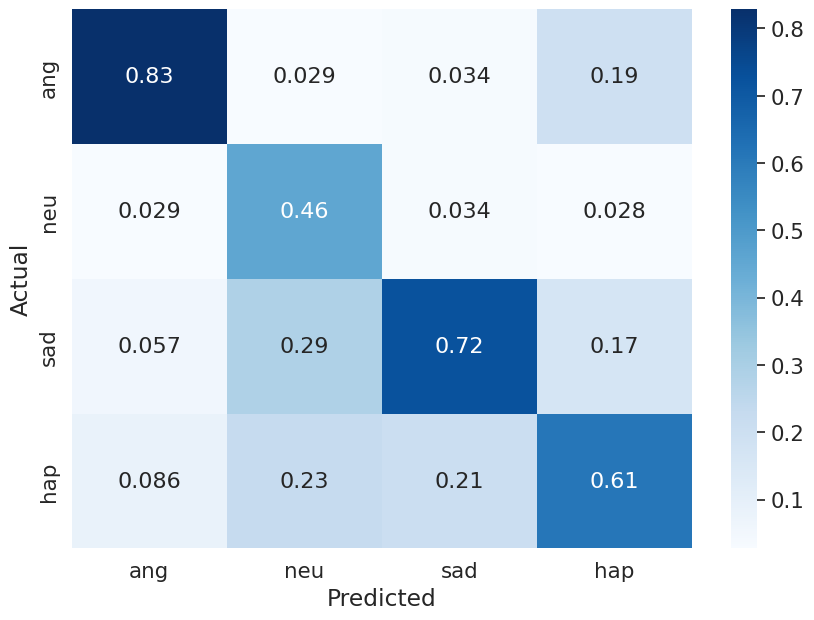

In [46]:
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

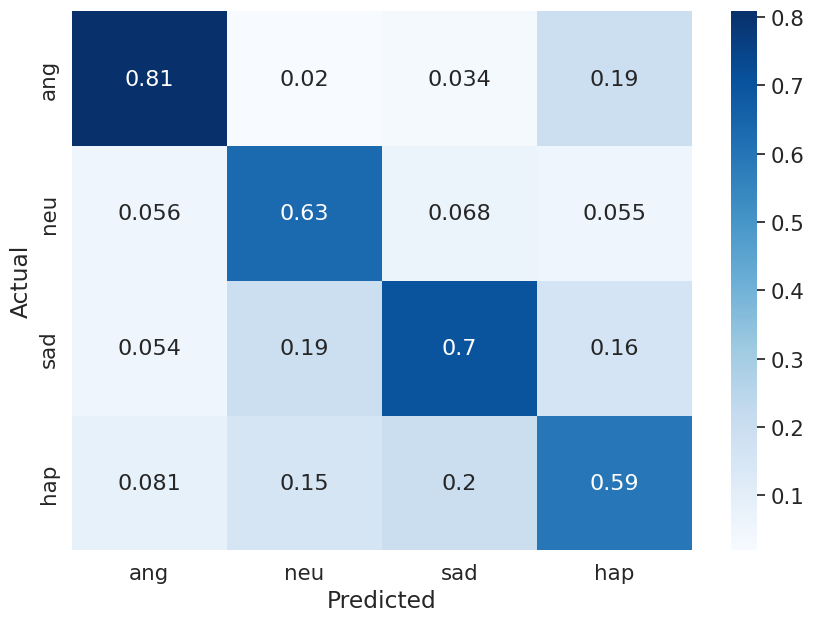

In [47]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [48]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

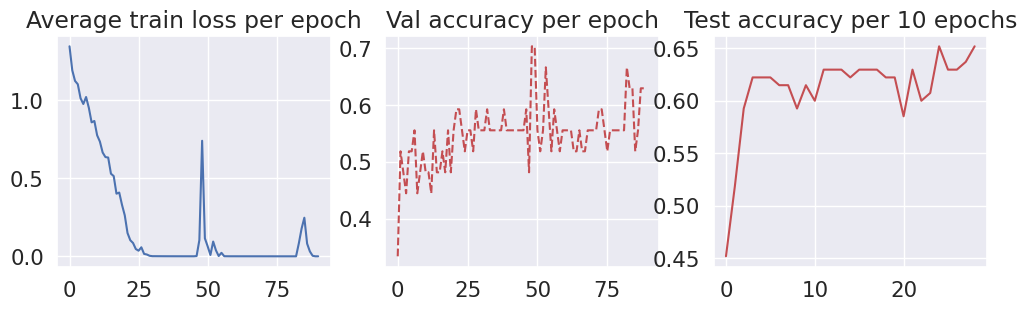

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

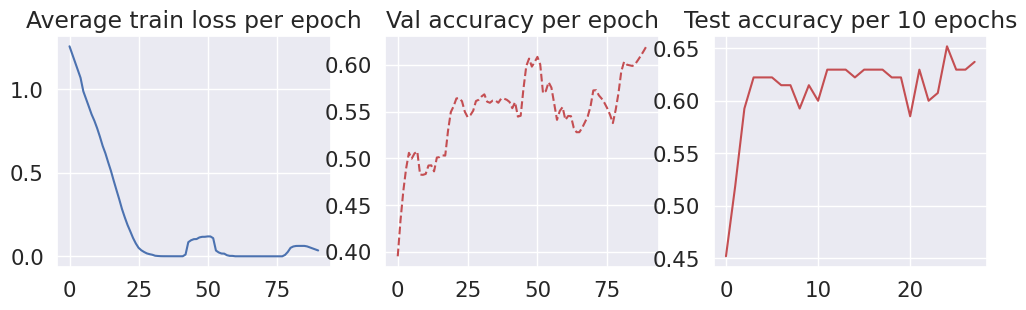

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(savgol_filter(train_losses, 10, 1), color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [55]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': trainer.best_test_model_path
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")